### Wednesday, January 3, 2024

[Understanding pipelines, models and schedulers](https://huggingface.co/docs/diffusers/using-diffusers/write_own_pipeline)

docker container start hfpt_Dec14

This all runs.

# Understanding pipelines, models and schedulers

🧨 Diffusers is designed to be a user-friendly and flexible toolbox for building diffusion systems tailored to your use-case. At the core of the toolbox are models and schedulers. While the [DiffusionPipeline](https://huggingface.co/docs/diffusers/main/en/api/pipelines/overview#diffusers.DiffusionPipeline) bundles these components together for convenience, you can also unbundle the pipeline and use the models and schedulers separately to create new diffusion systems.

In this tutorial, you'll learn how to use models and schedulers to assemble a diffusion system for inference, starting with a basic pipeline and then progressing to the Stable Diffusion pipeline.

## Deconstruct a basic pipeline

A pipeline is a quick and easy way to run a model for inference, requiring no more than four lines of code to generate an image:

model_index.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

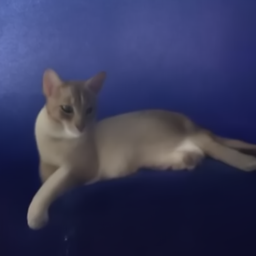

In [1]:
from diffusers import DDPMPipeline

ddpm = DDPMPipeline.from_pretrained("google/ddpm-cat-256").to("cuda")
image = ddpm(num_inference_steps=25).images[0]
image

<div class="flex justify-center">
    <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/ddpm-cat.png" alt="Image of cat created from DDPMPipeline"/>
</div>

That was super easy, but how did the pipeline do that? Let's breakdown the pipeline and take a look at what's happening under the hood.

In the example above, the pipeline contains a [UNet2DModel](https://huggingface.co/docs/diffusers/main/en/api/models/unet2d#diffusers.UNet2DModel) model and a [DDPMScheduler](https://huggingface.co/docs/diffusers/main/en/api/schedulers/ddpm#diffusers.DDPMScheduler). The pipeline denoises an image by taking random noise the size of the desired output and passing it through the model several times. At each timestep, the model predicts the *noise residual* and the scheduler uses it to predict a less noisy image. The pipeline repeats this process until it reaches the end of the specified number of inference steps.

To recreate the pipeline with the model and scheduler separately, let's write our own denoising process.

1. Load the model and scheduler:

In [2]:
from diffusers import DDPMScheduler, UNet2DModel

scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")
model = UNet2DModel.from_pretrained("google/ddpm-cat-256").to("cuda")

2. Set the number of timesteps to run the denoising process for:

In [3]:
scheduler.set_timesteps(50)

3. Setting the scheduler timesteps creates a tensor with evenly spaced elements in it, 50 in this example. Each element corresponds to a timestep at which the model denoises an image. When you create the denoising loop later, you'll iterate over this tensor to denoise an image:

In [4]:
scheduler.timesteps

tensor([980, 960, 940, 920, 900, 880, 860, 840, 820, 800, 780, 760, 740, 720,
        700, 680, 660, 640, 620, 600, 580, 560, 540, 520, 500, 480, 460, 440,
        420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180, 160,
        140, 120, 100,  80,  60,  40,  20,   0])

4. Create some random noise with the same shape as the desired output:

In [5]:
import torch

sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size)).to("cuda")

5. Now write a loop to iterate over the timesteps. At each timestep, the model does a [UNet2DModel.forward()](https://huggingface.co/docs/diffusers/main/en/api/models/unet2d#diffusers.UNet2DModel.forward) pass and returns the noisy residual. The scheduler's [step()](https://huggingface.co/docs/diffusers/main/en/api/schedulers/ddpm#diffusers.DDPMScheduler.step) method takes the noisy residual, timestep, and input and it predicts the image at the previous timestep. This output becomes the next input to the model in the denoising loop, and it'll repeat until it reaches the end of the `timesteps` array.

In [6]:
input = noise

for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample

This is the entire denoising process, and you can use this same pattern to write any diffusion system.

6. The last step is to convert the denoised output into an image:

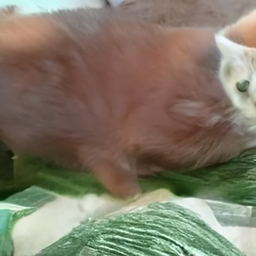

In [7]:
from PIL import Image
import numpy as np

image = (input / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
image = Image.fromarray((image * 255).round().astype("uint8"))
image

In the next section, you'll put your skills to the test and breakdown the more complex Stable Diffusion pipeline. The steps are more or less the same. You'll initialize the necessary components, and set the number of timesteps to create a `timestep` array. The `timestep` array is used in the denoising loop, and for each element in this array, the model predicts a less noisy image. The denoising loop iterates over the `timestep`'s, and at each timestep, it outputs a noisy residual and the scheduler uses it to predict a less noisy image at the previous timestep. This process is repeated until you reach the end of the `timestep` array.

Let's try it out!

## Deconstruct the Stable Diffusion pipeline

Stable Diffusion is a text-to-image *latent diffusion* model. It is called a latent diffusion model because it works with a lower-dimensional representation of the image instead of the actual pixel space, which makes it more memory efficient. The encoder compresses the image into a smaller representation, and a decoder to convert the compressed representation back into an image. For text-to-image models, you'll need a tokenizer and an encoder to generate text embeddings. From the previous example, you already know you need a UNet model and a scheduler.

As you can see, this is already more complex than the DDPM pipeline which only contains a UNet model. The Stable Diffusion model has three separate pretrained models.

<Tip>

💡 Read the [How does Stable Diffusion work?](https://huggingface.co/blog/stable_diffusion#how-does-stable-diffusion-work) blog for more details about how the VAE, UNet, and text encoder models.

</Tip>

Now that you know what you need for the Stable Diffusion pipeline, load all these components with the [from_pretrained()](https://huggingface.co/docs/diffusers/main/en/api/models/overview#diffusers.ModelMixin.from_pretrained) method. You can find them in the pretrained [`runwayml/stable-diffusion-v1-5`](https://huggingface.co/runwayml/stable-diffusion-v1-5) checkpoint, and each component is stored in a separate subfolder:

In [8]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

model_name = "CompVis/stable-diffusion-v1-4"

vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained(model_name, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_name, subfolder="text_encoder")
unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet")

# 61m 12.3s

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [9]:
!ls /root/.cache/huggingface/hub

models--CompVis--stable-diffusion-v1-4
models--TheBloke--CodeLlama-34B-Instruct-GPTQ
models--TheBloke--Llama-2-13b-Chat-GPTQ
models--google--ddpm-cat-256
models--google--ddpm-celebahq-256
models--google--ddpm-church-256
models--microsoft--Orca-2-13b
models--mistralai--Mistral-7B-Instruct-v0.2
models--runwayml--stable-diffusion-v1-5
models--stabilityai--sd-vae-ft-mse
version.txt
version_diffusers_cache.txt


In [ ]:
# docker cp c8324b70601d:///root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4 /home/rob/Data3/huggingface/transformers
# Successfully copied 4.27GB to /home/rob/Data3/huggingface/transformers

Instead of the default [PNDMScheduler](https://huggingface.co/docs/diffusers/main/en/api/schedulers/pndm#diffusers.PNDMScheduler), exchange it for the [UniPCMultistepScheduler](https://huggingface.co/docs/diffusers/main/en/api/schedulers/unipc#diffusers.UniPCMultistepScheduler) to see how easy it is to plug a different scheduler in:

In [10]:
from diffusers import UniPCMultistepScheduler

scheduler = UniPCMultistepScheduler.from_pretrained(model_name, subfolder="scheduler")

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

To speed up inference, move the models to a GPU since, unlike the scheduler, they have trainable weights:

In [11]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

### Create text embeddings

The next step is to tokenize the text to generate embeddings. The text is used to condition the UNet model and steer the diffusion process towards something that resembles the input prompt.

<Tip>

💡 The `guidance_scale` parameter determines how much weight should be given to the prompt when generating an image.

</Tip>

Feel free to choose any prompt you like if you want to generate something else!

In [12]:
prompt = ["a photograph of an astronaut riding a horse"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.manual_seed(0)  # Seed generator to create the inital latent noise
batch_size = len(prompt)

Tokenize the text and generate the embeddings from the prompt:

In [13]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

You'll also need to generate the *unconditional text embeddings* which are the embeddings for the padding token. These need to have the same shape (`batch_size` and `seq_length`) as the conditional `text_embeddings`:

In [14]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

Let's concatenate the conditional and unconditional embeddings into a batch to avoid doing two forward passes:

In [15]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

### Create random noise

Next, generate some initial random noise as a starting point for the diffusion process. This is the latent representation of the image, and it'll be gradually denoised. At this point, the `latent` image is smaller than the final image size but that's okay though because the model will transform it into the final 512x512 image dimensions later.

<Tip>

💡 The height and width are divided by 8 because the `vae` model has 3 down-sampling layers. You can check by running the following:

In [16]:
2 ** (len(vae.config.block_out_channels) - 1) == 8

True

</Tip>

In [17]:
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)

/tmp/ipykernel_17255/2341608825.py:2: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


### Denoise the image

Start by scaling the input with the initial noise distribution, *sigma*, the noise scale value, which is required for improved schedulers like [UniPCMultistepScheduler](https://huggingface.co/docs/diffusers/main/en/api/schedulers/unipc#diffusers.UniPCMultistepScheduler):

In [18]:
latents = latents * scheduler.init_noise_sigma

The last step is to create the denoising loop that'll progressively transform the pure noise in `latents` to an image described by your prompt. Remember, the denoising loop needs to do three things:

1. Set the scheduler's timesteps to use during denoising.
2. Iterate over the timesteps.
3. At each timestep, call the UNet model to predict the noise residual and pass it to the scheduler to compute the previous noisy sample.

In [19]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/25 [00:00<?, ?it/s]

### Decode the image

The final step is to use the `vae` to decode the latent representation into an image and get the decoded output with `sample`:

In [20]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

Lastly, convert the image to a `PIL.Image` to see your generated image!

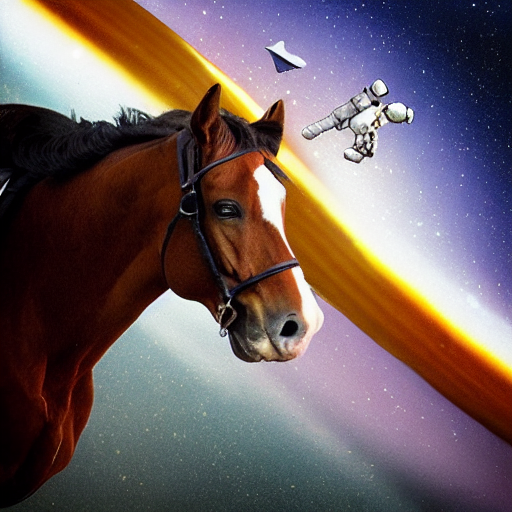

In [21]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

<div class="flex justify-center">
    <img src="https://huggingface.co/blog/assets/98_stable_diffusion/stable_diffusion_k_lms.png"/>
</div>

## Next steps

From basic to complex pipelines, you've seen that all you really need to write your own diffusion system is a denoising loop. The loop should set the scheduler's timesteps, iterate over them, and alternate between calling the UNet model to predict the noise residual and passing it to the scheduler to compute the previous noisy sample.

This is really what 🧨 Diffusers is designed for: to make it intuitive and easy to write your own diffusion system using models and schedulers.

For your next steps, feel free to:

* Learn how to [build and contribute a pipeline](https://huggingface.co/docs/diffusers/main/en/using-diffusers/contribute_pipeline) to 🧨 Diffusers. We can't wait and see what you'll come up with!
* Explore [existing pipelines](https://huggingface.co/docs/diffusers/main/en/using-diffusers/../api/pipelines/overview) in the library, and see if you can deconstruct and build a pipeline from scratch using the models and schedulers separately.